<a href="https://colab.research.google.com/github/BYU-Handwriting-Lab/GettingStarted/blob/solution/notebooks/named-entity-recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Named-Entity-Recognition in TensorFlow 2

This notebook contains code to do Named Entity Reconition in TensorFlow 2.

## Imports and Dependencies

TensorFlow Addons apparently has an implementation of CRF that is compatible with TF2 and tf.keras.

In [1]:
# TensorFlow
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa
import tensorflow.keras as K
import tensorflow.keras.layers as L

# Python
import os
import string
import re
import random

# Data Structures
import numpy as np
import pandas as pd
import json

# Image/Plotting
from matplotlib import pyplot as plt
from sklearn import metrics
import seaborn as sns

# Debugging
from tqdm import tqdm
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode='Plain', color_scheme='LightBg', tb_offset=1) # Change to 'Verbose' mode for additional debugging

In [8]:
# Insert file path to Esposalles Dataset in your Google Drive
# Note that '!' indicates a shell command rather than python code...

# French NER
# ID: 1Uc5_820EbfjN1-iFwr3JtpIyHzPdIl9g
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Uc5_820EbfjN1-iFwr3JtpIyHzPdIl9g' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Uc5_820EbfjN1-iFwr3JtpIyHzPdIl9g" -O french_ner_dataset.txt && rm -rf /tmp/cookies.txt

# French Text
# ID: 1M26Gpca8Ug4YvRLxoUDDCjMBeJtojITY
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1wDMLz9hTmfvPhkhCHTylbeAU6Utpkqb1' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1wDMLz9hTmfvPhkhCHTylbeAU6Utpkqb1" -O french_text.txt && rm -rf /tmp/cookies.t

# Word Embedding Weights
# ID: 1fF4wo-nTHLWENpCSQ6Q4NTsGr60SPmOM
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1fF4wo-nTHLWENpCSQ6Q4NTsGr60SPmOM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1fF4wo-nTHLWENpCSQ6Q4NTsGr60SPmOM" -O french_embedding_weights.npy && rm -rf /tmp/cookies.t

## Encoding Class

The encoding class helps us map between strings and indexes.

In [3]:
DEFAULT_CHARS = ' !"#$%&\'()*+,-./0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_`abcdefghijklmnopqrstuvwxyz|~£§¨«¬\xad' \
                '°²´·º»¼½¾ÀÂÄÇÈÉÊÔÖÜßàáâäæçèéêëìîïñòóôöøùúûüÿłŒœΓΖΤάήαδεηικλμνξοπρτυχψωόώІ‒–—†‡‰‹›₂₤℔⅓⅔⅕⅖⅗⅘⅙⅚⅛∆∇∫≠□♀♂✓ｆ'
# The default list of non-punctuation characters needed for the word beam search decoding algorithm
DEFAULT_NON_PUNCTUATION = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzÀÂÄÇÈÉÊÔÖÜßàáâäæçèéêëìîïñòóôöøùúûüÿ' \
                          'łŒœΓΖΤάήαδεηικλμνξοπρτυχψωόώІ'

DEFAULT_PUNCTUATION = string.punctuation + '0123456789'

In [4]:
lines = open('french_text.txt', 'r', encoding='utf8').readlines()

french_words = []
for line in lines:
    french_words.extend(line.split())
french_words = ' '.join(french_words)

In [5]:
class Tokenizer:
    def __init__(self, corpus, word_chars, punctuation, lower=False):
        self.word_chars = word_chars
        self.punctuation = punctuation
        self.regex = r"[" + self.word_chars + r"]+|[^\s]" 

        words = self.split(corpus)
        all_words_list = words + list(punctuation)
        all_words_list_unique = list(set(all_words_list))
        all_words = [' '.join(all_words_list_unique)]

        self.total_tokens = len(all_words_list_unique) + 2 # +2 to account for 0 (reserved) and 1 (OOV)
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=self.total_tokens, filters='', lower=lower, oov_token='<OOV>')
        self.tokenizer.fit_on_texts(all_words)

    def split(self, text):
        return re.findall(self.regex, text)

    def texts_to_sequences(self, text):
        words = self.split(text)
        return self.tokenizer.texts_to_sequences([' '.join(words)])
    
    def sequences_to_texts(self, sequences):
        return self.tokenizer.sequences_to_texts(sequences)

In [16]:
df = pd.read_csv('french_ner_dataset.txt', sep='\t', names=['word', 'entity', 'id'], header=None)
df.loc[df['entity'] == 'Primaryname', 'entity'] = 'PrimaryName'

entities = list(set(list(df['entity']))) + ['Start']
print('Possible Entities:', entities)

entity2idx = {}
idx2entity = {}

for index, entity in enumerate(entities):
    entity2idx[entity] = index
    idx2entity[index] = entity

Possible Entities: ['PrimaryName', 'none', 'Date', 'Age', 'Place', 'Name', 'Start']


In [12]:
idx2entity[6]

'Start'

In [17]:
tokenizer = Tokenizer(french_words, DEFAULT_NON_PUNCTUATION, DEFAULT_PUNCTUATION)

data = df.values

sentences = []
labels = []

sentence = []
label = []
current_id = 0
for word, entity, id in data:
    if current_id != id and len(sentence) != 0:

        sentences.append(sentence)
        labels.append(label)

        sentence = []
        label = []

        current_id = id
        entity = 'Start'

    tokens = tokenizer.texts_to_sequences(word)[0]
    idx = entity2idx[entity]
    for token in tokens:
        sentence.append(token)
        label.append(idx)

if len(sentence) != 0:
    sentences.append(sentence)
    labels.append(label)

random.

In [18]:
dataset = tf.data.Dataset.from_tensor_slices((words, labels))
for word, entity in dataset.take(1):
    print(word)
    print(entity)

tf.Tensor(28964, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)


In [19]:
dataset.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=18944>

## Model Architecture

This is where we can build our model using the tf.keras high-level API

We subclass from tf.keras.Model and implement the *call* method. This is the *forward pass* of the neural network.

In [24]:
reg = tf.keras.regularizers.L2(l2=0.00)

class NERModel(K.Model):
  def __init__(self, input_dim=25_000, output_dim=128, num_classes=8, embedding_weights=None, trainable=True):
    super(NERModel, self).__init__()

    self.embedding = L.Embedding(input_dim=input_dim, output_dim=output_dim, mask_zero=True, trainable=trainable, weights=embedding_weights)
    self.conv1 = tf.keras.Sequential(name='conv1')
    self.conv1.add(L.Conv1D(128, 5, padding='same', kernel_regularizer=reg))
    self.conv1.add(L.LayerNormalization())
    self.conv1.add(L.ReLU())
    self.conv1.add(L.Dropout(0.2))

    self.conv2 = tf.keras.Sequential(name='conv2')
    self.conv2.add(L.Conv1D(128, 5, padding='same', kernel_regularizer=reg))
    self.conv2.add(L.LayerNormalization())
    self.conv2.add(L.ReLU())
    self.conv2.add(L.Dropout(0.2))

    self.conv3 = tf.keras.Sequential(name='conv3')
    self.conv3.add(L.Conv1D(128, 5, padding='same', kernel_regularizer=reg))
    self.conv3.add(L.LayerNormalization())
    self.conv3.add(L.ReLU())
    self.conv3.add(L.Dropout(0.2))

    self.conv4 = tf.keras.Sequential(name='conv4')
    self.conv4.add(L.Conv1D(128, 5, padding='same', kernel_regularizer=reg))
    self.conv4.add(L.LayerNormalization())
    self.conv4.add(L.ReLU())
    self.conv4.add(L.Dropout(0.2))

    self.gru = L.Bidirectional(L.GRU(64, return_sequences=True, stateful=True, kernel_regularizer=reg))

    self.dense = L.Dense(num_classes, kernel_regularizer=reg)

  def __call__(self, x, **kwargs):
    out = self.embedding(x)
    out = tf.expand_dims(out, 0)
    conv1_out = self.conv1(out)
    # out = conv1_out
    out = out + conv1_out
    conv2_out = self.conv2(out)
    out = out + conv2_out
    conv3_out = self.conv3(out)
    out = out + conv3_out
    conv4_out = self.conv4(out)
    out = out + conv4_out
    gru_out = self.gru(out)
    out = out + gru_out
    out = self.dense(out)
    out = tf.squeeze(out, 0)

    return out

### Test to make sure the model is doing what we think it is...

The output shape should be (NUM_WORDS_IN_SENTENCE, NUM_CLASSES). Example: (41, 6)

The values along Axis=0 represents a word

The values along Axis=1 represents the probability distribution

In [25]:
pretrained_embedding_weights = np.load('french_embedding_weights.npy')

model = NERModel(input_dim=tokenizer.total_tokens, num_classes=len(entity2idx), trainable=True)

for word, entity in dataset.batch(5).take(1):
    results = model(word)
    print('Shape of output from NER Model: ', results.shape)
    print('Probability Distribution for one word in the sentence: ', results[0])
    print('Predicted class for the word: ', tf.argmax(results[0]).numpy())

Shape of output from NER Model:  (5, 7)
Probability Distribution for one word in the sentence:  tf.Tensor(
[ 2.9564328 -4.4269395 -2.4401822 -2.4701166 -2.6263266 -3.4725106
  3.245573 ], shape=(7,), dtype=float32)
Predicted class for the word:  6


## Evaluation Metrics

For named-entity-recognition, we will use Precision, Recall, and F1 for our
metrics. An easy way to do this is using sklearn metrics. We need to define
custom functions so that we can pass the *average* parameter when it's wrapped
in a *tf.py_function*.

In [26]:
def precision_score(y_true, y_pred):
  return metrics.precision_score(y_true, y_pred, average='macro')

def recall_score(y_true, y_pred):
  return metrics.recall_score(y_true, y_pred, average='macro')

def f1_score(y_true, y_pred):
  return metrics.f1_score(y_true, y_pred, average='macro')

## Training Loop

Build our training loop and creating custom train_step and val_step functions.

GradientTape allows us to keep track of the losses and gradients for each pass through the network. Structuring our code this way makes it much easier for debugging purposes and for us to iterate through our design.

Notice the decorator *@tf.function*. This tells TensorFlow to create the computation graph from the python code and allows our model to run much faster. The *experimental_relax_shapes* parameter allows us to pass tensors with various sentence lengths without TensorFlow getting upset at us.

TensorFlow 2 also does some weird things with scope when it constructs the computation graph through a @tf.function annotation. Thus, if we use a more object oriented approach, we can avoid some of the nasty scope issues. See the following articles for more details:
* https://pgaleone.eu/tensorflow/tf.function/2019/03/21/dissecting-tf-function-part-1/
* https://pgaleone.eu/tensorflow/tf.function/2019/04/03/dissecting-tf-function-part-2/


In [27]:
class Train:
  def __init__(self):
    # How many times through the training set should we go?
    self.epochs = 100
    self.batch_size = 16
    self.num_classes = len(idx2entity)

    # Break up dataset into training/validation
    dataset = tf.data.Dataset.from_tensor_slices((words, labels))

    dataset_size = dataset.cardinality().numpy()
    self.train_dataset_size = int(dataset_size * 0.8)
    self.val_dataset_size = dataset_size - self.train_dataset_size

    self.train_dataset = dataset.take(self.train_dataset_size).batch(self.batch_size).shuffle(500)
    self.val_dataset = dataset.skip(self.train_dataset_size).batch(self.batch_size)

    embedding_weights = [np.load('french_embedding_weights.npy')]

    # Create our model
    self.model = NERModel(input_dim=tokenizer.total_tokens,
                          num_classes=self.num_classes,
                          embedding_weights=embedding_weights,
                          trainable=True)

    # Use CrossEntropy for our loss function and Adam for our optimizer
    self.loss_fn = K.losses.SparseCategoricalCrossentropy(from_logits=True)
    self.optimizer = K.optimizers.Adam(learning_rate=1e-3)

    # Metrics to track our performance
    # Consider adding metrics like Precision/Recall here...
    self.train_pred_loss = tf.keras.metrics.Mean(name='train_pred_loss')
    self.train_reg_loss = tf.keras.metrics.Mean(name='train_reg_loss')
    self.train_precision = tf.keras.metrics.Mean(name='train_precision')
    self.train_recall = tf.keras.metrics.Mean(name='train_recall')
    self.train_f1 = tf.keras.metrics.Mean(name='train_f1')
    self.val_pred_loss = tf.keras.metrics.Mean(name='val_pred_loss')
    self.val_reg_loss = tf.keras.metrics.Mean(name='val_reg_loss')
    self.val_precision = tf.keras.metrics.Mean(name='val_precision')
    self.val_recall = tf.keras.metrics.Mean(name='val_recall')
    self.val_f1 = tf.keras.metrics.Mean(name='val_f1')

  @tf.function(experimental_relax_shapes=True)
  def train_step(self, words, labels, ones):
    with tf.GradientTape() as tape:
      # Make a prediction, calculate the loss
      predictions = self.model(words, training=True)
      pred_loss = self.loss_fn(labels, predictions)
      reg_loss = tf.reduce_sum(self.model.losses)
      loss = pred_loss + reg_loss

    # Obtain gradients from GradientTape
    gradients = tape.gradient(loss, self.model.trainable_variables)

    # Propagate loss back through the network and take a step with the optimizer  
    self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
    
    # Update our metrics
    results = tf.argmax(predictions, axis=1)
    precision = tf.py_function(precision_score, [labels, results], Tout=[tf.float32])
    recall = tf.py_function(recall_score, [labels, results], Tout=[tf.float32])
    f1 = tf.py_function(f1_score, [labels, results], Tout=[tf.float32])

    self.train_pred_loss(pred_loss)
    self.train_reg_loss(reg_loss)
    self.train_precision(precision)
    self.train_recall(recall)
    self.train_f1(f1)

  @tf.function(experimental_relax_shapes=True)
  def validation_step(self, words, labels, ones):
    # Make a prediction and calculate the loss
    predictions = self.model(words, training=False)
    pred_loss = self.loss_fn(labels, predictions)
    reg_loss = tf.reduce_sum(self.model.losses)
    loss = pred_loss + reg_loss

    # Update our metrics
    results = tf.argmax(predictions, axis=1)
    precision = tf.py_function(precision_score, [labels, results], Tout=[tf.float32])
    recall = tf.py_function(recall_score, [labels, results], Tout=[tf.float32])
    f1 = tf.py_function(f1_score, [labels, results], Tout=[tf.float32])

    self.val_pred_loss(pred_loss)
    self.val_reg_loss(reg_loss)
    self.val_precision(precision)
    self.val_recall(recall)
    self.val_f1(f1)

  def __call__(self):
    # Variables to keep track of our progress through the entire training process
    # Used below when we create our graphs
    try:
      train_losses, val_losses = [], []
      train_precisions, val_precisions = [], []
      train_recalls, val_recalls = [], []
      train_f1s, val_f1s = [], []

      for epoch in range(self.epochs):
        # Reset Metrics for another epoch
        self.train_pred_loss.reset_states()
        self.train_reg_loss.reset_states()
        self.train_precision.reset_states()
        self.train_recall.reset_states()
        self.train_f1.reset_states()
        self.val_pred_loss.reset_states()
        self.val_reg_loss.reset_states()
        self.val_precision.reset_states()
        self.val_recall.reset_states()
        self.val_f1.reset_states()

        # self.model.lstm.reset_states()

        # Training Loop
        train_loop = tqdm(total=int(np.round(self.train_dataset_size/self.batch_size)), position=0, leave=True)
        for words, labels in self.train_dataset:
          # One training iteration
          self.train_step(words, labels, tf.ones(labels.shape[0], dtype=tf.int32))
          train_loop.set_description('Train - Epoch: {}, PredLoss: {:.4f}, RegLoss: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}'.format(
              epoch, self.train_pred_loss.result(), self.train_reg_loss.result(), self.train_precision.result(), self.train_recall.result(), self.train_f1.result()))
          train_loop.update(1)
        train_loop.close()

        # self.model.lstm.reset_states()

        # Validation Loop
        val_loop = tqdm(total=int(np.round(self.val_dataset_size/self.batch_size)), position=0, leave=True)
        for words, labels in self.val_dataset:
          # One validation iteration
          self.validation_step(words, labels, tf.ones(labels.shape[0], dtype=tf.int32))
          val_loop.set_description('Val  - Epoch: {}, PredLoss: {:.4f}, RegLoss: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}'.format(
              epoch, self.val_pred_loss.result(), self.val_reg_loss.result(), self.val_precision.result(), self.val_recall.result(), self.val_f1.result()))
          val_loop.update(1)
        val_loop.close()

        train_losses.append(self.train_pred_loss.result() + self.train_reg_loss.result())
        val_losses.append(self.val_pred_loss.result() + self.val_reg_loss.result())

        train_precisions.append(self.train_precision.result())
        val_precisions.append(self.val_precision.result())

        train_recalls.append(self.train_recall.result())
        val_recalls.append(self.val_recall.result())

        train_f1s.append(self.train_f1.result())
        val_f1s.append(self.val_f1.result())
    except:
      __ITB__()
    finally:
      return self.model, (train_losses, val_losses), (train_precisions, val_precisions), (train_recalls, val_recalls), (train_f1s, val_f1s)

In [ ]:
try:
  train = Train()
  model, losses, precisions, recalls, f1s = train()
except:
  __ITB__()

  0%|          | 0/947 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Train - Epoch: 0, PredLoss: 0.4456, RegLoss: 0.0000, Precision: 0.7634, Recall: 0.7477, F1: 0.7434: : 948it [01:17, 12.27it/s]
Val  - Epoch: 0, PredLoss: 0.4890, RegLoss: 0.0000, Precision: 0.7428, Recall: 0.7224, F1: 0.7180: 100%|██████████| 237/237 [00:04<00:00, 49.83it/s]
Train - Epoch: 1, PredLoss: 0.1265, RegLoss: 0.0000, Precision: 0.9176, Recall: 0.9086, F1: 0.907

## Results

Show how our model did throughout the training process.

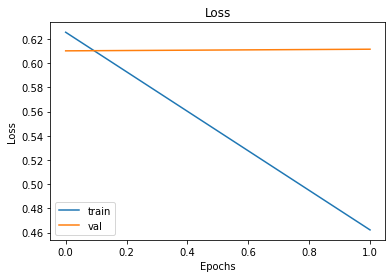

Final Validation Loss: 0.6116


In [ ]:
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(losses[0], label='train')
plt.plot(losses[1], label='val')
plt.legend()
plt.show()
print('Final Validation Loss: {:.4f}'.format(losses[1][-1]))

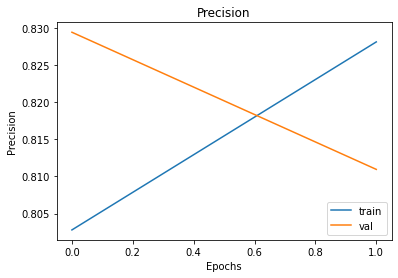

Final Validation Precision: 81.09%


In [ ]:
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.plot(precisions[0], label='train')
plt.plot(precisions[1], label='val')
plt.legend()
plt.show()
print('Final Validation Precision: {:.2f}%'.format(precisions[1][-1] * 100))

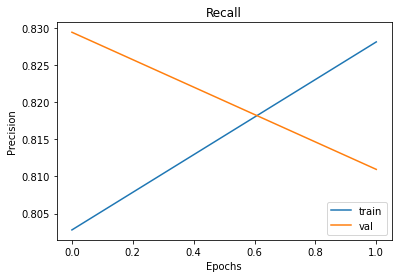

Final Validation Recall: 81.09%


In [ ]:
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.plot(recalls[0], label='train')
plt.plot(recalls[1], label='val')
plt.legend()
plt.show()
print('Final Validation Recall: {:.2f}%'.format(recalls[1][-1] * 100))

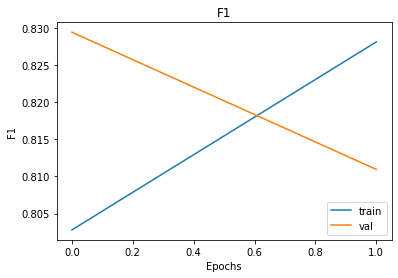

Final Validation F1: 81.09%


In [ ]:
plt.title('F1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.plot(f1s[0], label='train')
plt.plot(f1s[1], label='val')
plt.legend()
plt.show()
print('Final Validation F1: {:.2f}%'.format(f1s[1][-1] * 100))

## Examples and Confusion Matrix

* Show the final confusion matrix on the validation set.
* Show a couple examples of the model classifying text.

In [ ]:
example_size = 10000

dataset_size = dataset.cardinality().numpy()
train_dataset_size = int(dataset_size * 0.8)
val_dataset_size = dataset_size - train_dataset_size

val_dataset = dataset.skip(train_dataset_size).batch(1)

y_true = []
y_pred = []

for word, label in val_dataset.take(example_size):
    output = model(word, training=False)
    prediction = tf.squeeze(tf.argmax(output, 1)).numpy()
    y_pred.append(prediction)
    prediction = idx2entity[prediction]
    label = tf.squeeze(label).numpy()
    y_true.append(label)
    label = idx2entity[label]
    word = tf.expand_dims(word, 0).numpy()
    word = tokenizer.sequences_to_texts(word)[0]

    print('Word: {} -- Prediction: {} -- Actual: {}'.format(word, prediction, label))

Word: St -- Prediction: DeathPlace -- Actual: none
Word: Cyr -- Prediction: DeathPlace -- Actual: none
Word: - -- Prediction: DeathPlace -- Actual: none
Word: sur -- Prediction: none -- Actual: none
Word: - -- Prediction: DeathPlace -- Actual: none
Word: le -- Prediction: none -- Actual: none
Word: - -- Prediction: DeathPlace -- Actual: none
Word: Rhône -- Prediction: none -- Actual: none
Word: lesquels -- Prediction: none -- Actual: none
Word: nous -- Prediction: none -- Actual: none
Word: ont -- Prediction: none -- Actual: none
Word: déclaré -- Prediction: none -- Actual: none
Word: que -- Prediction: none -- Actual: none
Word: Bonnefond -- Prediction: none -- Actual: Name
Word: Etienne -- Prediction: none -- Actual: Name
Word: François -- Prediction: none -- Actual: Name
Word: , -- Prediction: none -- Actual: Name
Word: cultivateur -- Prediction: none -- Actual: none
Word: né -- Prediction: none -- Actual: none
Word: en -- Prediction: none -- Actual: none
Word: la -- Prediction: non

In [ ]:
metrics.confusion_matrix(y_true, y_pred)

array([[   0,    0,    0,    0,    3,   93,    0,    0],
       [   0,    0,    0,    0,    2,   26,    0,    0],
       [   0,    0,   23,    0,    0,   64,    0,    0],
       [   0,    0,    1,    0,    0,    8,    0,    0],
       [   0,    0,    0,    0,   18,   32,    0,    0],
       [   0,    0,    6,    0,   23, 1210,    0,    2],
       [   0,    0,    8,    0,    0,   36,    0,    0],
       [   0,    0,    0,    0,    0,   11,    0,    5]])

In [ ]:
# The number of examples to show how the model did
num_examples = 10

# Determine sizes for training and validation sets
dataset_size = 20000
train_dataset_size = int(.8 * dataset_size)
val_dataset_size = dataset_size - train_dataset_size

# Break up dataset into training/validation
dataset = tf.data.Dataset.from_generator(
    conll_generator,
    (tf.int64, tf.int32)).take(dataset_size)
val_dataset = dataset.skip(train_dataset_size).batch(16)

y_true, y_pred = np.array([]), np.array([])

print('Making Predictions for Validation Set...')
for index, (words, labels) in enumerate(val_dataset):   
  predictions = model(words)
  y_true = np.concatenate((y_true, labels.numpy()))
  y_pred = np.concatenate((y_pred, tf.argmax(predictions, axis=1).numpy()))

  if index < num_examples:
    print('***Entity Prediction Sample***')
    for word, actual, pred in zip(words, labels.numpy(), tf.argmax(predictions, axis=1).numpy()):
      print('Word: {}, Predicted: {}, Actual: {}, Accuracy: {}'.format(word, actual, pred, '100%' if pred == actual else '0%'))

print('Finished.')

NameError: ignored

Use sklearn to create the confusion matrix from the actual/predicted values

In [ ]:
matrix = metrics.confusion_matrix(y_true, y_pred)
matrix

array([[   0,    0,    0,    0,    3,   93,    0,    0],
       [   0,    0,    0,    0,    2,   26,    0,    0],
       [   0,    0,   23,    0,    0,   64,    0,    0],
       [   0,    0,    1,    0,    0,    8,    0,    0],
       [   0,    0,    0,    0,   18,   32,    0,    0],
       [   0,    0,    6,    0,   23, 1210,    0,    2],
       [   0,    0,    8,    0,    0,   36,    0,    0],
       [   0,    0,    0,    0,    0,   11,    0,    5]])

In [ ]:
metrics.classification_report(y_true, y_pred, labels=class_labels)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to 

'              precision    recall  f1-score   support\n\n   OtherName       0.00      0.00      0.00         0\n        Name       0.00      0.00      0.00         0\n   DeathDate       0.00      0.00      0.00         0\n    DeathAge       0.00      0.00      0.00         0\n  DeathPlace       0.00      0.00      0.00         0\n        none       0.00      0.00      0.00         0\n   BirthDate       0.00      0.00      0.00         0\n       Start       0.00      0.00      0.00         0\n\n   micro avg       0.00      0.00      0.00         0\n   macro avg       0.00      0.00      0.00         0\nweighted avg       0.00      0.00      0.00         0\n'

Print the Heatmap and convert the index class labels back to their original
text representation.

Text(123.0, 0.5, 'Actual')

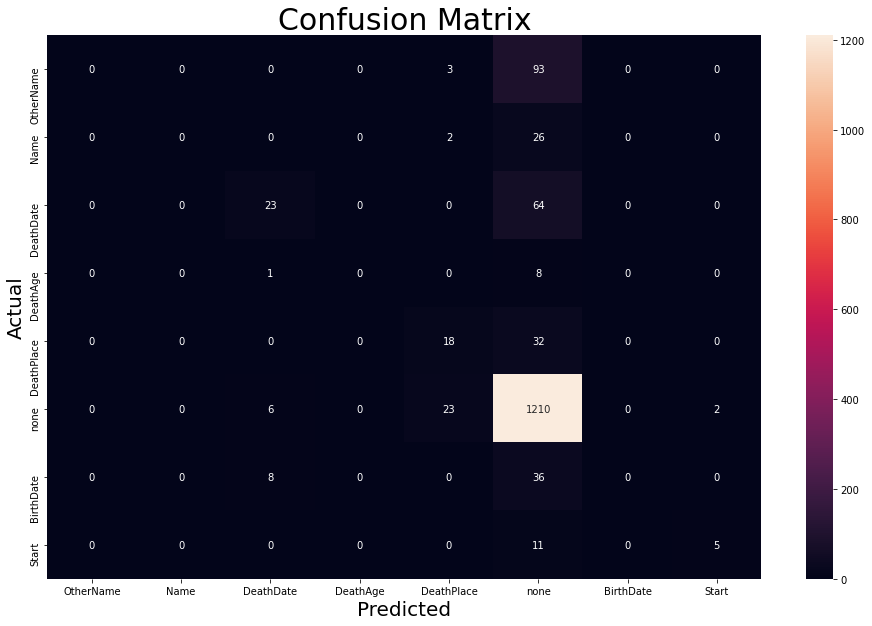

In [ ]:
class_labels = [e for e in entity2idx]

plt.figure(figsize = (16, 10))
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix', fontdict={'fontsize': 30})
plt.xlabel('Predicted', fontdict={'fontsize': 20})
plt.ylabel('Actual', fontdict={'fontsize': 20})